# CORINE land cover 2018 data

<https://land.copernicus.eu/pan-european/corine-land-cover/clc2018>

In [1]:
# import libraries
import multiprocessing
import os
import platform
from datetime import datetime, timezone
from zipfile import BadZipFile, ZipFile

# Windows
if platform.system() == "Windows":
    import multiprocessing.popen_spawn_win32
# Linux/OSX
else:
    import multiprocessing.popen_spawn_posix

import threading
import xml.etree.ElementTree as ET

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from dask.distributed import Client, LocalCluster, Lock
from dask.utils import SerializableLock
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-04-26 16:38:19.739796+00:00


In [3]:
# define data directories
DATA_DIR_BASE = os.path.join("data", "land-cover", "clc-2018")

In [4]:
# the ZIP file containing the CLC 2018 data should be moved to this folder
DATA_DIR = os.path.join(DATA_DIR_BASE, "raw")

In [8]:
os.listdir(DATA_DIR)

['83684d24c50f069b613e0dc8e12529b893dc172f.zip']

In [9]:
ZIP_FILE = os.path.join(
    DATA_DIR, "83684d24c50f069b613e0dc8e12529b893dc172f.zip"
)

In [7]:
# list of files/folders in the ZIP archive
ZipFile(ZIP_FILE).namelist()

['u2018_clc2018_v2020_20u1_raster100m.zip']

In [8]:
# extract the archive
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [5]:
ZIP_FILE = os.path.join(DATA_DIR, "u2018_clc2018_v2020_20u1_raster100m.zip")

In [10]:
# list of TIF files in the new ZIP archive
for i in ZipFile(ZIP_FILE).namelist():
    if i.endswith(".tif"):
        print(i)

u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif
u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_GLP.tif
u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_GUF.tif
u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_MTQ.tif
u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_MYT.tif
u2018_clc2018_v2020_20u1_raster100m/DATA/French_DOMs/U2018_CLC2018_V2020_20u1_FR_REU.tif


In [11]:
# extract the ZIP file
try:
    z = ZipFile(ZIP_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", ZIP_FILE)

In [5]:
DATA_DIR = os.path.join(
    DATA_DIR_BASE, "raw", "u2018_clc2018_v2020_20u1_raster100m", "DATA"
)

In [6]:
FILE_PATH = os.path.join(DATA_DIR, "U2018_CLC2018_V2020_20u1.tif")

In [7]:
# read the CLC 2018 raster
# use Dask for parallel computing
# https://corteva.github.io/rioxarray/stable/examples/dask_read_write.html
with LocalCluster() as cluster, Client(cluster) as client:
    landcover = rxr.open_rasterio(
        FILE_PATH,
        chunks=True,
        cache=False,
        lock=False,
        # lock=Lock("rio-read", client=client)  # when too many file handles
        #                                       # open
    )
    landcover.rio.to_raster(
        os.path.join(DATA_DIR_BASE, "dask_multiworker.tif"),
        tiled=True,
        lock=Lock("rio", client=client)
    )

2023-04-26 17:38:28,919 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.19 GiB -- Worker memory limit: 1.87 GiB
2023-04-26 17:38:30,308 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.31 GiB -- Worker memory limit: 1.87 GiB
2023-04-26 17:38:30,836 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [8]:
landcover

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
dask.array<open_rasterio-8d39b0b49c59f4c7a7ad1dbc3aaceaaa<this-array>, shape=(1, 46000, 65000), dtype=int8, chunksize=(1, 11520, 11520), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int64 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836
    _FillValue:              -128
    scale_factor:            1.0
    add_offset:              0.0

In [9]:
landcover.rio.resolution()

(100.0, -100.0)

In [10]:
landcover.rio.bounds()

(900000.0, 900000.0, 7400000.0, 5500000.0)

In [11]:
landcover.rio.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]')

In [12]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [13]:
# convert the boundary's CRS to match the CLC raster's CRS
ie.to_crs(landcover.rio.crs, inplace=True)

In [14]:
ie

,NAME,DESCRIPTION,geometry
0,Ireland,Boundary for the Island of Ireland generated u...,"MULTIPOLYGON (((2943334.202 3358983.857, 29440..."


In [15]:
# clip land cover to Ireland's boundary
landcover = rxr.open_rasterio(
    FILE_PATH, cache=False, masked=True
).rio.clip(ie["geometry"], from_disk=True)

In [16]:
landcover

<xarray.DataArray (band: 1, y: 3961, x: 4050)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 2.925e+06 2.925e+06 ... 3.329e+06 3.329e+06
  * y            (y) float64 3.722e+06 3.722e+06 ... 3.326e+06 3.326e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836
    scale_factor:            1.0
    add_offset:              0.0

In [17]:
landcover.rio.bounds()

(2924500.0, 3326300.0, 3329500.0, 3722400.0)

In [18]:
# export to GeoTIFF
landcover.rio.to_raster(
    os.path.join(DATA_DIR_BASE, "clc-2018-ie.tif"), windowed=True, tiled=True
)

In [19]:
# get unique value count for the raster
uniquevals = gpd.GeoDataFrame(
    np.unique(landcover, return_counts=True)
).transpose()
# assign column names
uniquevals.columns = ["value", "count"]

In [20]:
# drop row(s) with NaN
uniquevals.dropna(inplace=True)
# sort by count
uniquevals = uniquevals.sort_values("count", ascending=False)
# convert value column to string
uniquevals["value"] = uniquevals["value"].astype(int).astype(str)

In [21]:
uniquevals

,value,count
13,18,4779044.0
27,36,1021610.0
15,21,508503.0
17,24,371866.0
11,12,360712.0
21,29,239577.0
20,27,188930.0
31,41,169123.0
19,26,150786.0
1,2,148763.0


In [22]:
# read the QGIS style file containing the legend entries
tree = ET.parse(
    os.path.join(
        DATA_DIR_BASE,
        "raw",
        "u2018_clc2018_v2020_20u1_raster100m",
        "Legend",
        "clc_legend_qgis_raster.qml"
    )
)
root = tree.getroot()

In [23]:
# extract colour palette
pal = {}

for palette in root.iter("paletteEntry"):
    pal[palette.attrib["value"]] = palette.attrib

In [24]:
# generate data frame from palette dictionary
legend = gpd.GeoDataFrame.from_dict(pal).transpose()
legend = gpd.GeoDataFrame(legend)

In [25]:
# convert value column to string
legend["value"] = legend["value"].astype(str)
legend.drop(columns="alpha", inplace=True)

In [26]:
legend

,color,label,value
1,#e6004d,111 - Continuous urban fabric,1
2,#ff0000,112 - Discontinuous urban fabric,2
3,#cc4df2,121 - Industrial or commercial units,3
4,#cc0000,122 - Road and rail networks and associated land,4
5,#e6cccc,123 - Port areas,5
6,#e6cce6,124 - Airports,6
7,#a600cc,131 - Mineral extraction sites,7
8,#a64d00,132 - Dump sites,8
9,#ff4dff,133 - Construction sites,9
10,#ffa6ff,141 - Green urban areas,10


In [27]:
# merge unique value dataframe with legend
uniquevals = uniquevals.merge(legend, on="value")
uniquevals = uniquevals.sort_values("count", ascending=False)

In [28]:
# calculate percentage based on count
uniquevals["percentage"] = (
    uniquevals["count"] / uniquevals["count"].sum() * 100
)
uniquevals["percentage"] = uniquevals["percentage"].round(1)

In [29]:
uniquevals

,value,count,color,label,percentage
0,18,4779044.0,#e6e64d,231 - Pastures,56.8
1,36,1021610.0,#4d4dff,412 - Peat bogs,12.1
2,21,508503.0,#e6cc4d,243 - Land principally occupied by agriculture...,6.0
3,24,371866.0,#00a600,312 - Coniferous forest,4.4
4,12,360712.0,#ffffa8,211 - Non-irrigated arable land,4.3
5,29,239577.0,#a6f200,324 - Transitional woodland-shrub,2.8
6,27,188930.0,#a6ff80,322 - Moors and heathland,2.2
7,41,169123.0,#80f2e6,512 - Water bodies,2.0
8,26,150786.0,#ccf24d,321 - Natural grasslands,1.8
9,2,148763.0,#ff0000,112 - Discontinuous urban fabric,1.8


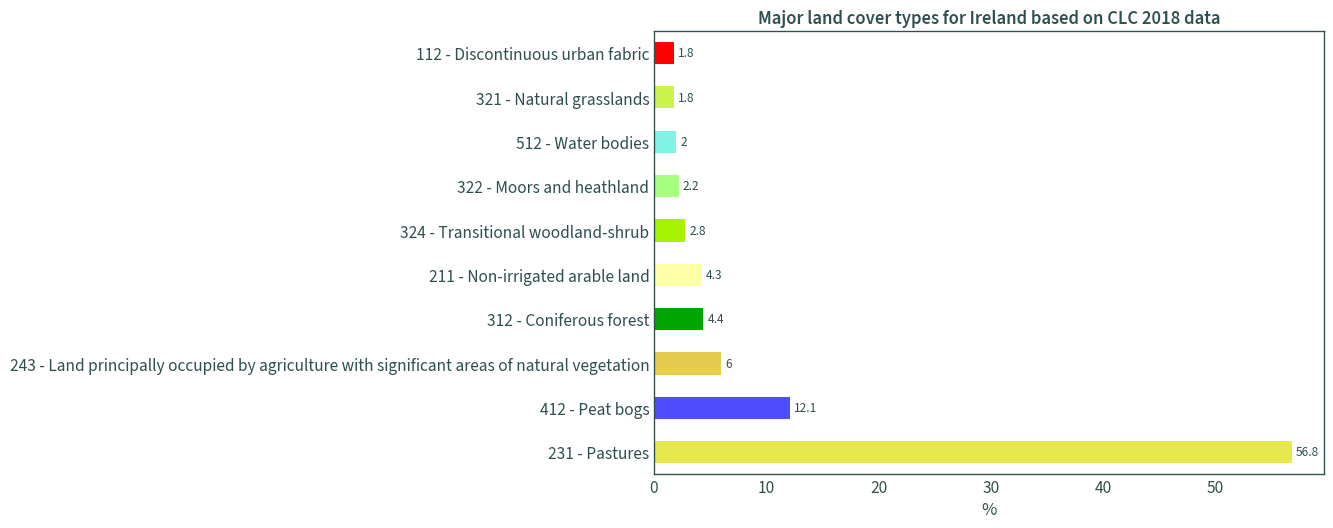

In [30]:
# plot major land cover types, i.e. percentage > 1
mask = uniquevals["percentage"] > 1
uniquevals_sig = uniquevals[mask]

ax = uniquevals_sig.plot.barh(
    x="label", y="percentage", legend=False, figsize=(9, 6),
    color=uniquevals_sig["color"]
)
ax.bar_label(ax.containers[0], padding=3)
plt.title("Major land cover types for Ireland based on CLC 2018 data")
plt.ylabel("")
plt.xlabel("%")
plt.show()

In [31]:
# convert values to integer and sort
uniquevals["value"] = uniquevals["value"].astype(int)
uniquevals.sort_values("value", inplace=True)

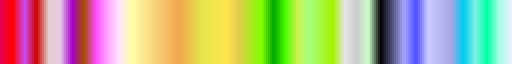

In [32]:
# create a colourmap for the plot
colours = list(uniquevals["color"])
nodes = np.array(uniquevals["value"])
# normalisation
nodes = (nodes - min(nodes)) / (max(nodes) - min(nodes))
colours = LinearSegmentedColormap.from_list(
    "CLC2018", list(zip(nodes, colours))
)
colours

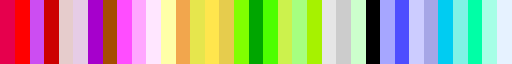

In [33]:
col_discrete = ListedColormap(list(uniquevals["color"]))
col_discrete

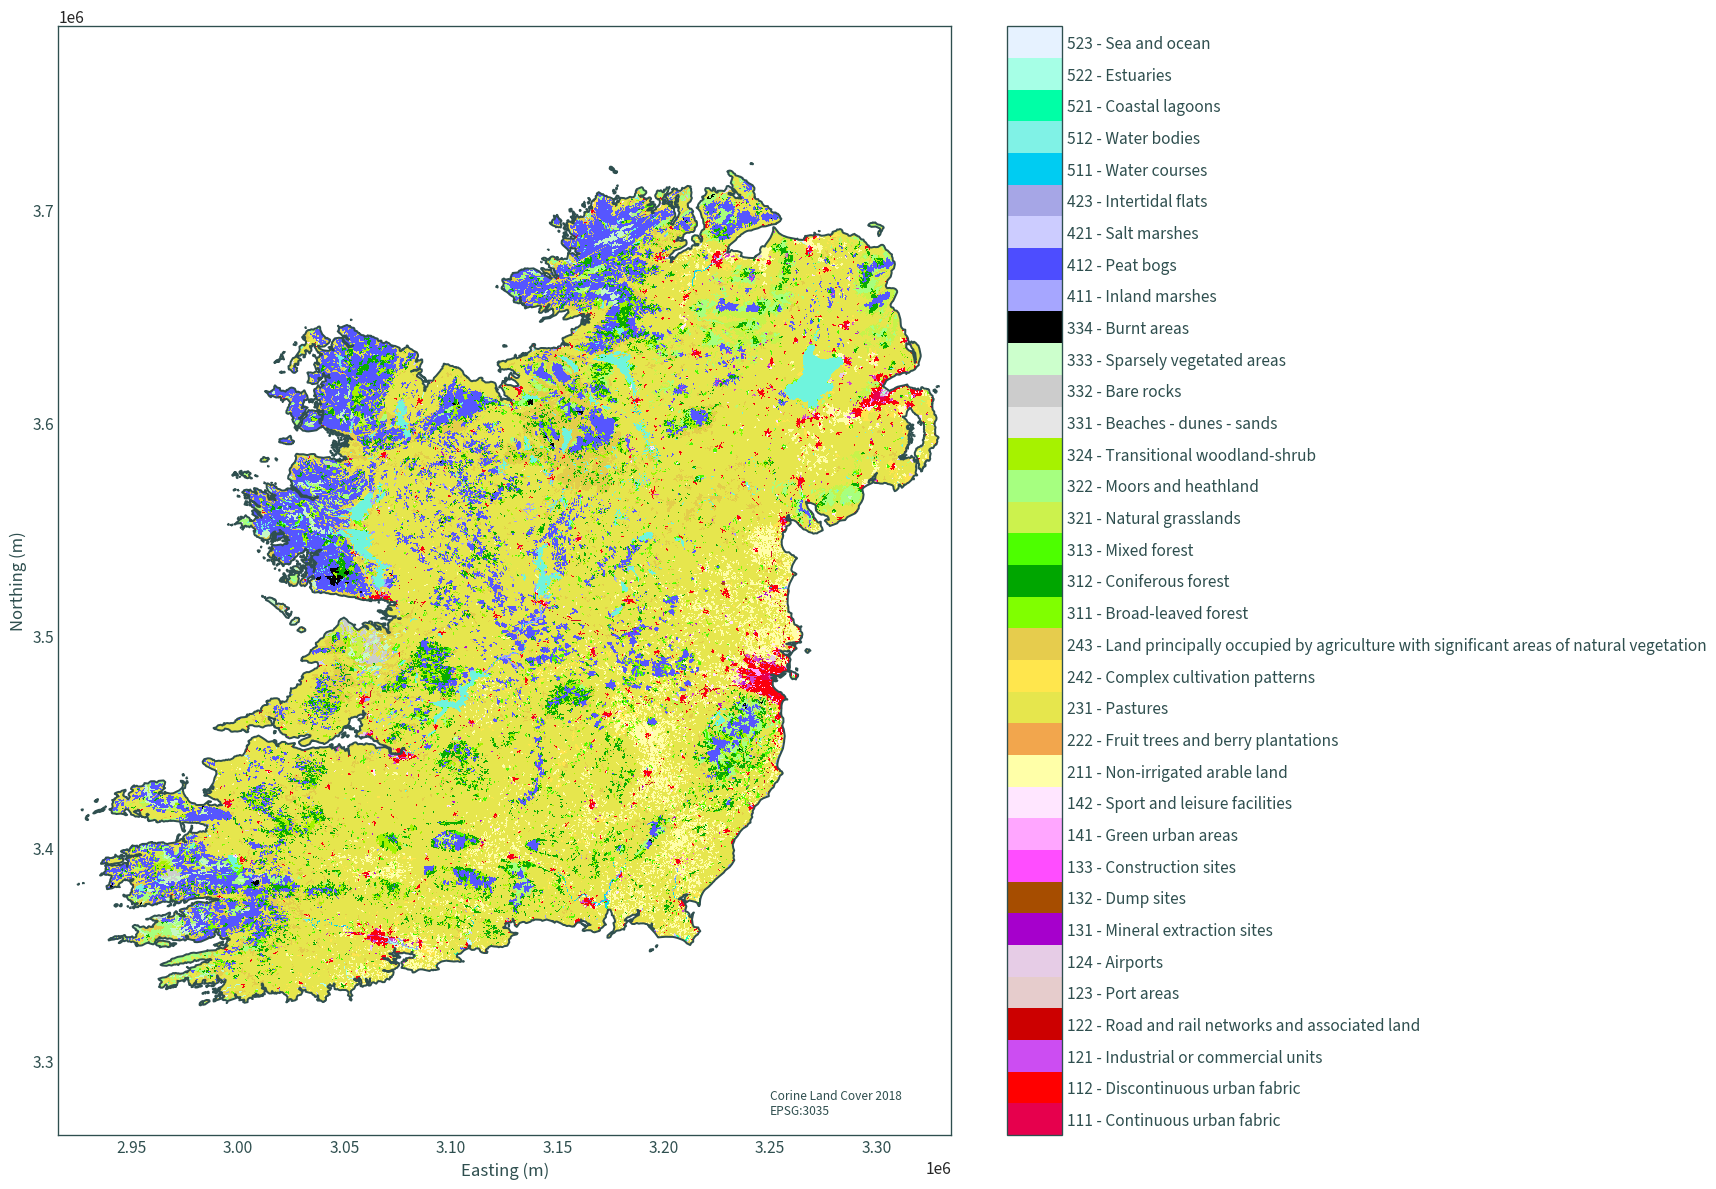

In [35]:
img = plt.figure(figsize=(15, 15))
img = plt.imshow(np.array([[0, len(uniquevals)]]), cmap=col_discrete)
img.set_visible(False)

ticks = list(np.arange(.5, len(uniquevals) + .5, 1))
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(list(uniquevals["label"]))

landcover.plot(add_colorbar=False, cmap=colours)

ie.boundary.plot(ax=img.axes, color="darkslategrey")

# plt.title("CLC 2018 - Ireland")
plt.title(None)

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

plt.axis("equal")
plt.text(
    3.25e6, 3.275e6, "Corine Land Cover 2018\nEPSG:3035"
)
plt.xlim(landcover.rio.bounds()[0] - 9e3, landcover.rio.bounds()[1] + 9e3)
plt.ylim(landcover.rio.bounds()[2] - 9e3, landcover.rio.bounds()[3] + 9e3)

plt.show()

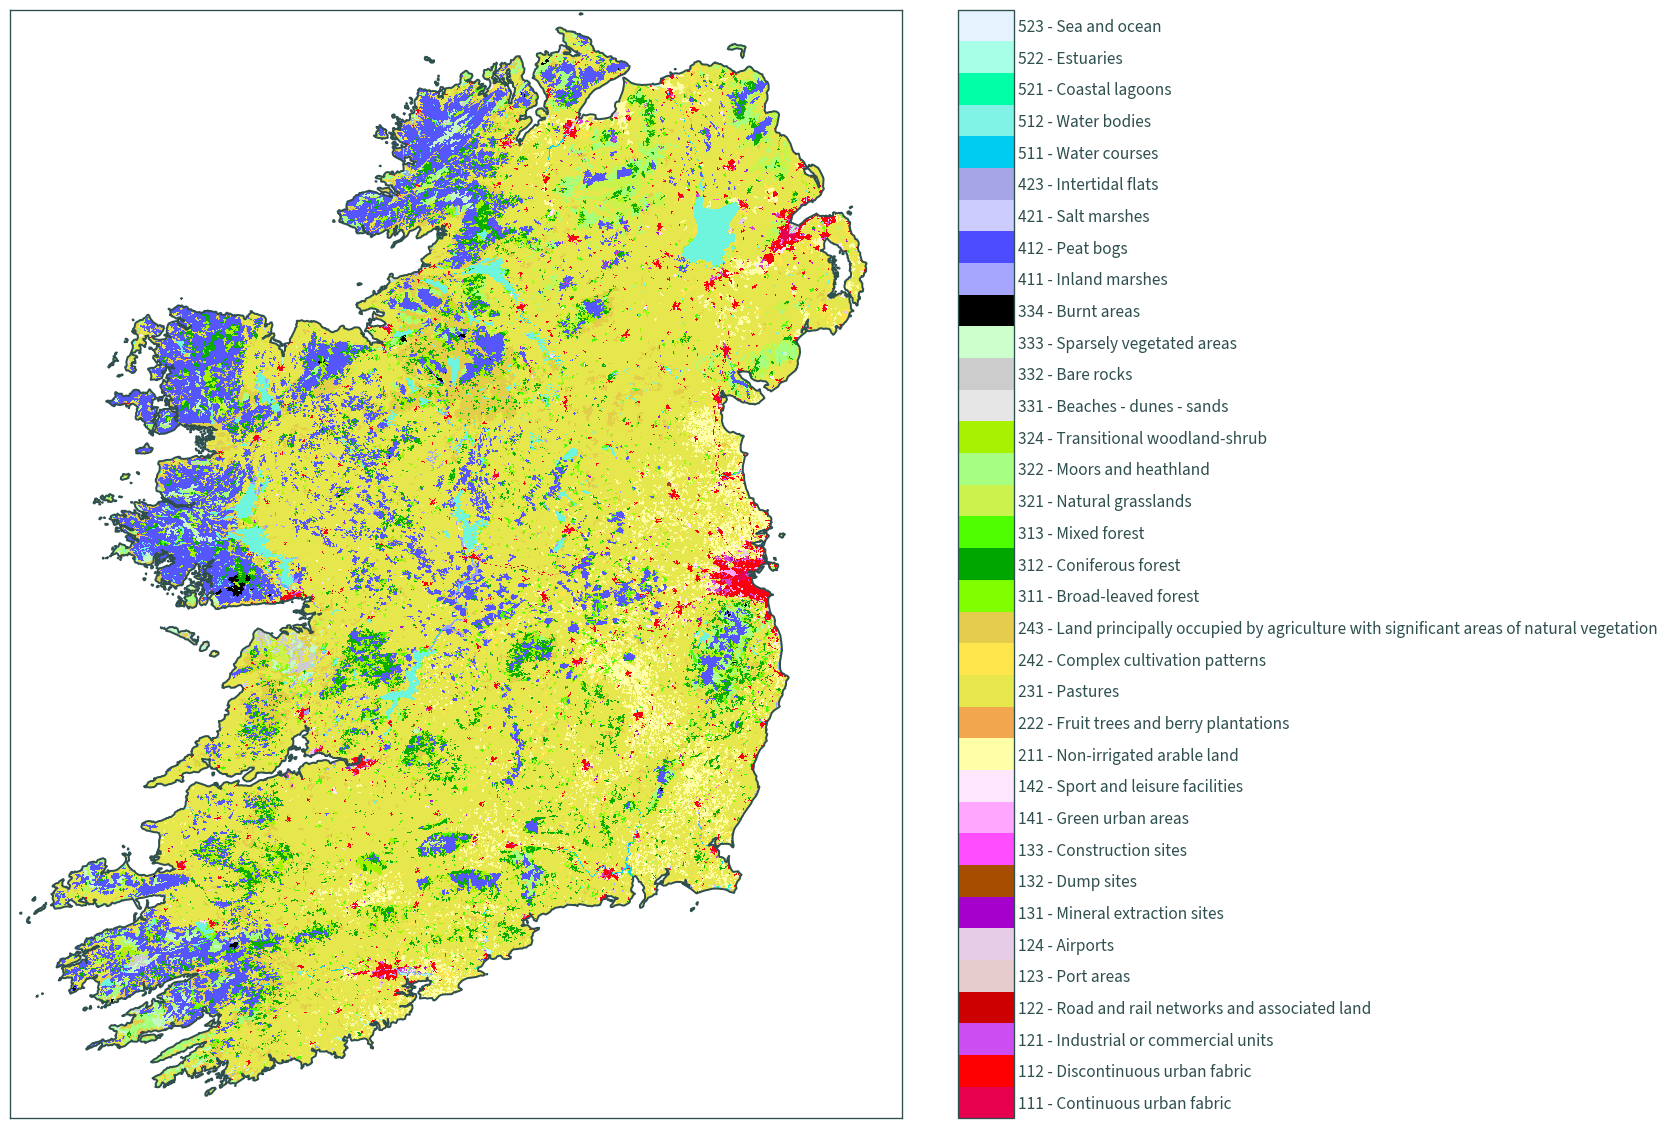

In [37]:
img = plt.figure(figsize=(15, 15))
img = plt.imshow(np.array([[0, len(uniquevals)]]), cmap=col_discrete)
img.set_visible(False)

ticks = list(np.arange(.5, len(uniquevals) + .5, 1))
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(list(uniquevals["label"]))

landcover.rio.reproject(cplt.plot_projection).plot(
    add_colorbar=False, cmap=colours
)

ie.to_crs(cplt.plot_projection).boundary.plot(
    ax=img.axes, edgecolor="darkslategrey"
)

plt.title(None)

img.axes.tick_params(labelbottom=False, labelleft=False)

plt.xlabel("")
plt.ylabel("")

plt.axis("equal")
plt.xlim(-1.5, 1.33)
plt.ylim(-2.05, 2.05)
# plt.xlim(landcover.rio.bounds()[0] - 9e3, landcover.rio.bounds()[1] + 9e3)
# plt.ylim(landcover.rio.bounds()[2] - 9e3, landcover.rio.bounds()[3] + 9e3)

plt.show()

In [39]:
# pastures
lc = landcover.where(landcover.compute() == 18, drop=True)

In [40]:
lc

<xarray.DataArray (band: 1, y: 3911, x: 3988)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 2.928e+06 2.928e+06 ... 3.329e+06 3.329e+06
  * y            (y) float64 3.719e+06 3.718e+06 ... 3.328e+06 3.328e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Thematic
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  136.429646247598
    STATISTICS_MAXIMUM:      48
    STATISTICS_MEAN:         25.753373398066
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.680310194836
    scale_factor:            1.0
    add_offset:              0.0

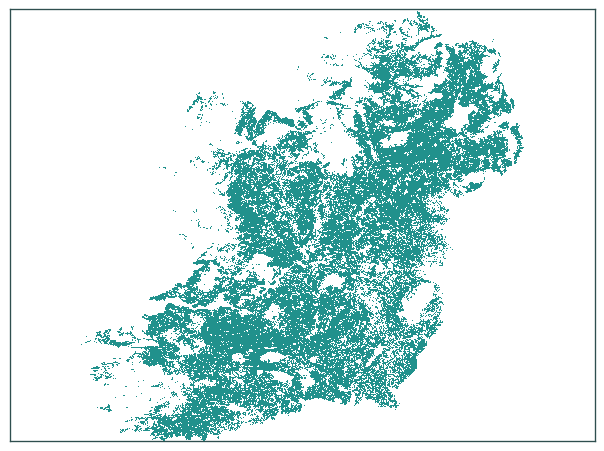

In [41]:
fig = lc.plot(add_colorbar=False)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.title(None)
plt.axis("equal")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [11]:
# export to GeoTIFF
lc.rio.to_raster(
    os.path.join(DATA_DIR_BASE, "clc-2018-ie-pasture.tif"),
    windowed=True, tiled=True
)

In [4]:
# vectorised (done in QGIS)
pasture = gpd.read_file(
    os.path.join(DATA_DIR_BASE, "clc-2018-pasture.gpkg"), layer="dissolved"
)

In [5]:
pasture

,VALUE,geometry
0,18.0,"MULTIPOLYGON (((3021511.237 3329200.000, 30215..."


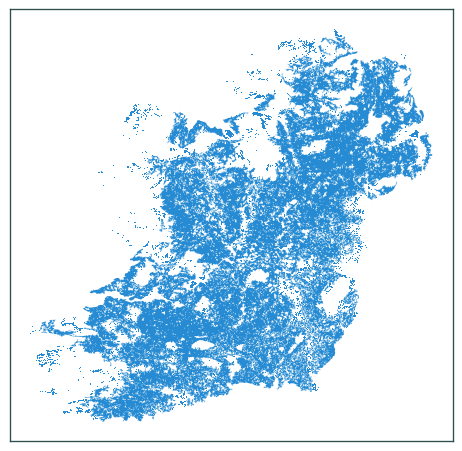

In [7]:
fig = pasture.plot()
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()